Investigate how having a lower lmax for the model than for the generated data
affects the results.

In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM

RS = SH.RealSphericalHarmonics()

3072 190


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


3072 190


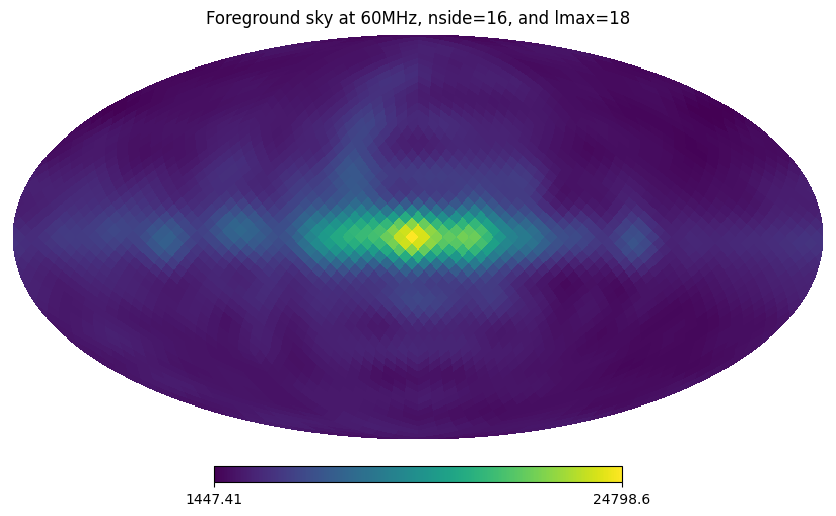

In [2]:
# Create a sky map of the foregrounds.
lmax = 18
nside = 2**4
npix = hp.nside2npix(nside)
ylm_mat = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax)

fg_alm, fg_map = SM.foreground_gdsm_alm(nu=60, lmax=lmax, nside=nside, map=True)
hp.mollview(fg_map, title=f"Foreground sky at 60MHz, nside={nside}, and lmax={lmax}")

# Calculate total observation matrix.
mat_A = FM.calc_observation_matrix_all_pix(
    nside=nside, 
    lmax=lmax, 
    Ntau=npix, 
    Nt=npix,
    beam_use=lambda theta: BF.beam_cos(theta, theta0=.8)
)
# Generate data.
data = mat_A @ fg_alm
noisy_data, noise_cov = SM.add_noise(data, dnu=1, Ntau=npix, t_int=1e4*npix)

3072 91
3072 91


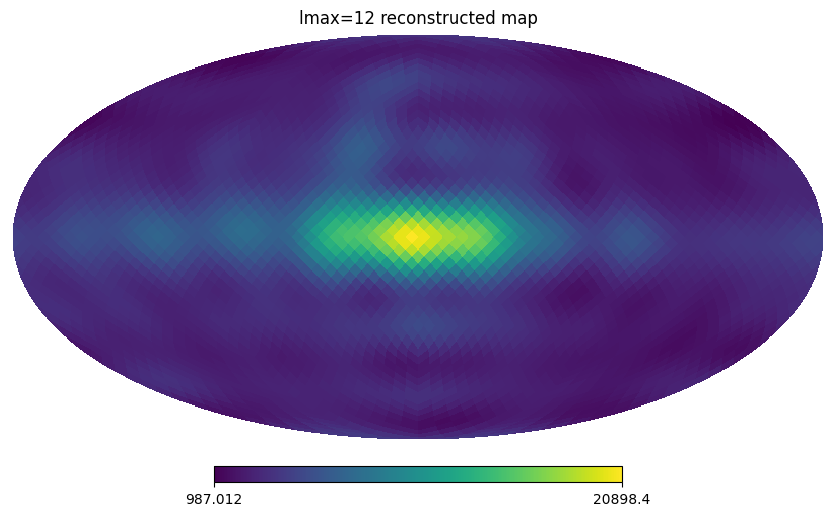

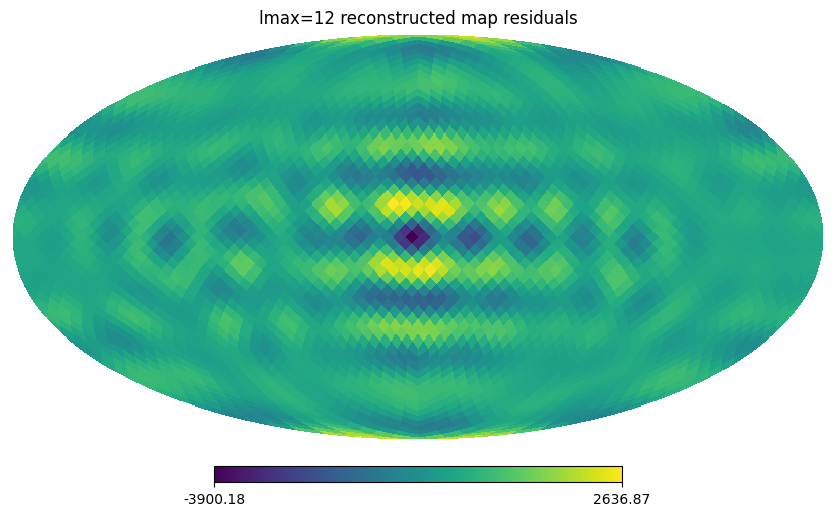

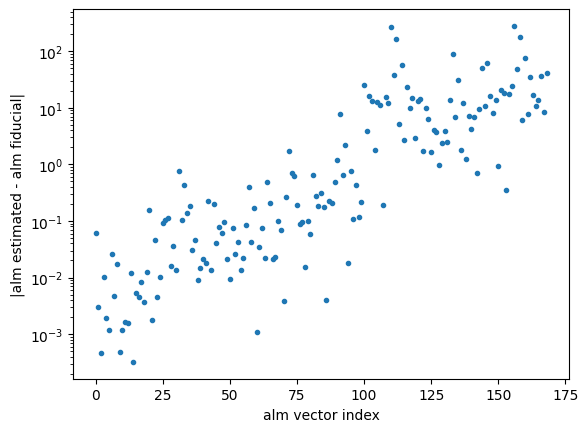

In [20]:
# Set up a fitting model with a different lmax.
lmax_mod = 12
ylm_mat_mod = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax_mod)

mat_A_mod = FM.calc_observation_matrix_all_pix(
    nside=nside, 
    lmax=lmax_mod, 
    Ntau=npix, 
    Nt=npix,
    beam_use=lambda theta: BF.beam_cos(theta, theta0=.8)
)

# Invert to make map.
mat_W, model_covar = MM.calc_ml_estimator_matrix(
    mat_A=mat_A_mod, 
    mat_N=noise_cov, 
    cov=True
)
model_estimate = mat_W @ noisy_data

# Plot
hp.mollview(ylm_mat_mod@model_estimate, title=f"lmax={lmax_mod} reconstructed map")
plt.show()

hp.mollview(ylm_mat_mod@model_estimate - ylm_mat@fg_alm, title=f"lmax={lmax_mod} reconstructed map residuals")
plt.show()

no_modes = np.min((len(model_estimate), len(fg_alm)))
plt.semilogy(range(no_modes), abs(model_estimate[:no_modes] - fg_alm[:no_modes]), '.')
plt.xlabel("alm vector index")
plt.ylabel("|alm estimated - alm fiducial|")
plt.show()

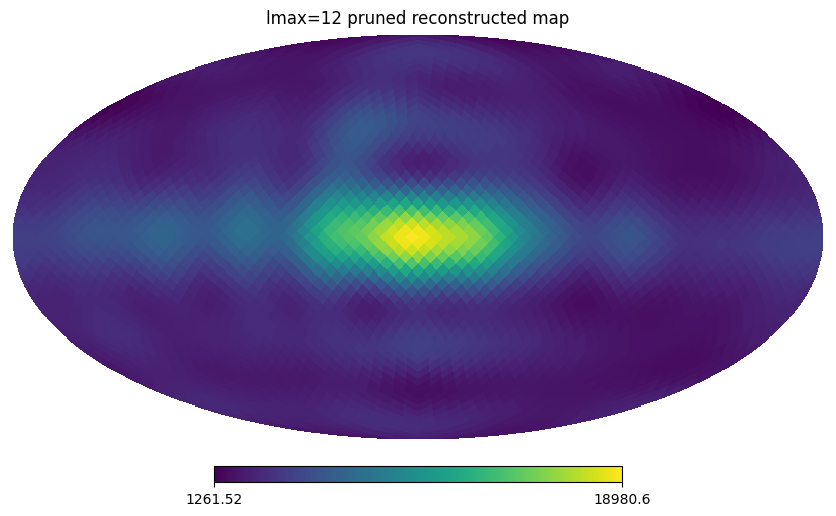

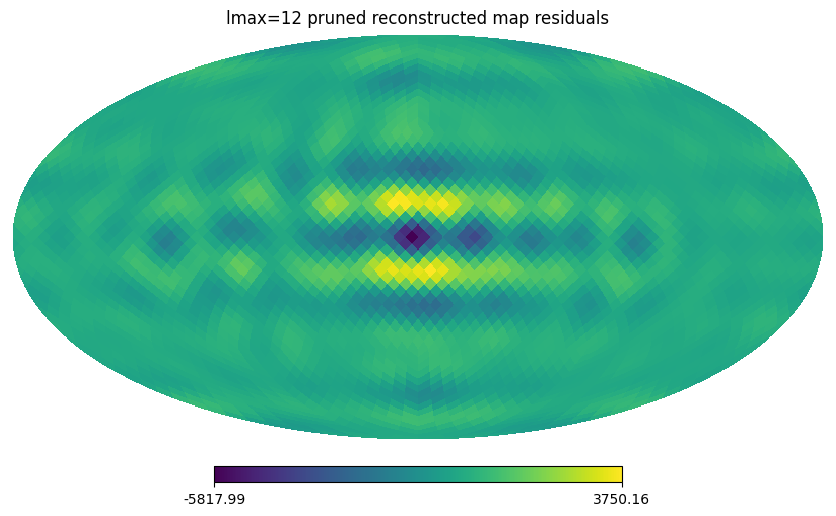

In [29]:
# See what cutting off higher order modes does for the reconstruction.
cutoff_index = 125
model_estimate_pruned = np.array(model_estimate)
model_estimate_pruned[cutoff_index:] = np.zeros(len(model_estimate_pruned[cutoff_index:]))

hp.mollview(ylm_mat_mod@model_estimate_pruned, title=f"lmax={lmax_mod} pruned reconstructed map")
plt.show()

hp.mollview(ylm_mat_mod@model_estimate_pruned - ylm_mat@fg_alm, title=f"lmax={lmax_mod} pruned reconstructed map residuals")
plt.show()